# Chapter 15

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# check if the libraries we need are installed

try:
    import pint
except ImportError:
    !pip install pint
    
try:
    import modsim
except ImportError:
    !pip install modsimpy

So far the systems we have studied have been physical in the sense that they exist in the world, but they have not been physics, in the sense of what physics classes are usually about. In the next few chapters, we'll do some physics, starting with **thermal systems**, that is, systems where the temperature of objects changes as heat transfers from one to another.

## The coffee cooling problem

The coffee cooling problem was discussed by Jearl Walker in 
"The Amateur Scientist", *Scientific American*, Volume 237, Issue 5, November 1977. Since then it has become a standard example of modeling and simulation.

Here is my version of the problem:

> Suppose I stop on the way to work to pick up a cup of coffee, which I take with milk. Assuming that I want the coffee to be as hot as possible when I arrive at work, should I add the milk at the coffee shop, wait until I get to work, or add the milk at some point in between?

To help answer this question, I made a trial run with the milk and
coffee in separate containers and took some measurements (not really):

-   When served, the temperature of the coffee is 90 °C. The volume is
    300 mL.

-   The milk is at an initial temperature of 5 °C, and I take about
    50 mL.

-   The ambient temperature in my car is 22 °C.

-   The coffee is served in a well insulated cup. When I arrive at work after 30 minutes, the temperature of the coffee has fallen to 70 °C.

-   The milk container is not as well insulated. After 15 minutes, it
    warms up to 20 °C, nearly the ambient temperature.

To use this data and answer the question, we have to know something
about temperature and heat, and we have to make some modeling decisions.

## Temperature and heat

To understand how coffee cools (and milk warms), we need a model of
temperature and heat. **Temperature** is a property of an object or a
system; in SI units it is measured in degrees Celsius (°C). Temperature quantifies how hot or cold the object is, which is related to the average velocity of the particles that make up the object.

When particles in a hot object contact particles in a cold object, the
hot object gets cooler and the cold object gets warmer as energy is
transferred from one to the other. The transferred energy is called
**heat**; in SI units it is measured in joules (J).

Heat is related to temperature by the following equation (see
<http://modsimpy.com/thermass>): 

$$Q = C~\Delta T$$ 

where $Q$ is the
amount of heat transferred to an object, $\Delta T$ is resulting change in temperature, and $C$ is the **thermal mass** of the object, which quantifies how much energy it takes to heat or cool it. In SI units, thermal mass is measured in joules per degree Celsius (J/°C).

For objects made primarily from one material, thermal mass can be
computed like this: 

$$C = m c_p$$ 

where $m$ is the mass of the object and $c_p$ is the **specific heat capacity** of the material (see <http://modsimpy.com/specheat>).

We can use these equations to estimate the thermal mass of a cup of
coffee. The specific heat capacity of coffee is probably close to that
of water, which is 4.2 J/g/°C. Assuming that the density of coffee is
close to that of water, which is 1 g/mL, the mass of 300 mL of coffee is 300 g, and the thermal mass is 1260 J/°C.

So when a cup of coffee cools from 90 °C to 70 °C, the change in
temperature, $\Delta T$ is 20 °C, which means that 25 200 J of heat
energy was transferred from the coffee to the surrounding environment
(the cup holder and air in my car).

To give you a sense of how much energy that is, if you were able to
harness all of that heat to do work (which you cannot), you could
use it to lift a cup of coffee from sea level to 8571 m, just shy of the height of Mount Everest, 8848 m.

Assuming that the cup has less mass than the coffee, and is made from a material with lower specific heat, we can ignore the thermal mass of the cup. For a cup with substantial thermal mass, like a ceramic mug, we might consider a model that computes the temperature of coffee and cup separately.

## Heat transfer

In a situation like the coffee cooling problem, there are three ways
heat transfers from one object to another (see <http://modsimpy.com/transfer>):

-   Conduction: When objects at different temperatures come into
    contact, the faster-moving particles of the higher-temperature
    object transfer kinetic energy to the slower-moving particles of the
    lower-temperature object.

-   Convection: When particles in a gas or liquid flow from place to
    place, they carry heat energy with them. Fluid flows can be caused
    by external action, like stirring, or by internal differences in
    temperature. For example, you might have heard that hot air rises,
    which is a form of "natural convection\".

-   Radiation: As the particles in an object move due to thermal energy,
    they emit electromagnetic radiation. The energy carried by this
    radiation depends on the object's temperature and surface properties
    (see <http://modsimpy.com/thermrad>).

For objects like coffee in a car, the effect of radiation is much
smaller than the effects of conduction and convection, so we will ignore it.

Convection can be a complex topic, since it often depends on details of fluid flow in three dimensions. But for this problem we will be able to get away with a simple model called "Newton's law of cooling".

## Newton's law of cooling

Newton's law of cooling asserts that the temperature rate of change for an object is proportional to the difference in temperature between the
object and the surrounding environment:

$$\frac{dT}{dt} = -r (T - T_{env})$$ 

where $T$, the temperature of the object, is a function of time, $t$; $T_{env}$ is the temperature of the environment, and $r$ is a constant that characterizes how quickly heat is transferred between the system and the environment.

Newton's so-called "law " is really a model: it is a good approximation in some conditions and less good in others.

For example, if the primary mechanism of heat transfer is conduction,
Newton's law is "true", which is to say that $r$ is constant over a
wide range of temperatures. And sometimes we can estimate $r$ based on
the material properties and shape of the object.

When convection contributes a non-negligible fraction of heat transfer, $r$ depends on temperature, but Newton's law is often accurate enough, at least over a narrow range of temperatures. In this case $r$ usually has to be estimated experimentally, since it depends on details of surface shape, air flow, evaporation, etc.

When radiation makes up a substantial part of heat transfer, Newton's
law is not a good model at all. This is the case for objects in space or in a vacuum, and for objects at high temperatures (more than a few
hundred degrees Celsius, say).

However, for a situation like the coffee cooling problem, we expect
Newton's model to be quite good.

## Implementation

To get started, let's forget about the milk temporarily and focus on the coffee. 

Here's a `System` object that contains the parameters of the system:

In [2]:
from modsim import System

def make_system(T_init, volume, r, t_end):
    return System(T_init=T_init,
                  volume=volume,
                  r=r,
                  t_end=t_end,
                  T_env=22,
                  t_0=0,
                  dt=1)

In [3]:
coffee = make_system(T_init=90, volume=300, r=0.01, t_end=30)

The values of `volume`, `T_env`, and `t_end` come from the statement of the problem. I chose the value of `r` arbitrarily for now; we will
figure out how to estimate it soon.

`dt` is the time step we use to simulate the cooling process. Strictly
speaking, Newton's law is a differential equation, but over a short
period of time we can approximate it with a difference equation:

$$\Delta T = -r (T - T_{env}) dt$$ 

where $dt$ is a small time step and
$\Delta T$ is the change in temperature during that time step.

Note: I use $\Delta T$ to denote a change in temperature over time, but in the context of heat transfer, you might also see $\Delta T$ used to denote the difference in temperature between an object and its
environment, $T - T_{env}$. To minimize confusion, I avoid this second
use.

Now we can write an update function:

In [4]:
def change_func(T, t, system):
    r, T_env, dt = system.r, system.T_env, system.dt    
    return -r * (T - T_env) * dt

Like previous update functions, this one takes a `State` object, a time,
and a `System` object.

Now if we run

In [5]:
change_func(coffee.T_init, 0, coffee)

-0.68

we see that the temperature after one minute is 89.3 °C, so the
temperature drops by about 0.7 °C/min, at least for this value of `r`.

Here's a version of `run_simulation` that simulates a series of time
steps from `t_0` to `t_end`:

In [6]:
from modsim import linrange
from pandas import Series
from numpy import empty

def run_simulation(system, change_func):
    t_array = linrange(system.t_0, system.t_end, system.dt)
    n = len(t_array)
    
    T_array = empty(n)
    T_array[0] = system.T_init
    
    for i in range(n-1):
        t = t_array[i]
        T = T_array[i]
        T_array[i+1] = T + change_func(T, t, system)
    
    system.T_final = T_array[-1]
    return Series(T_array, index=t_array)

This function is similar to previous versions of `run_simulation`.

One difference is that it uses `linrange` to make an array of values
from `t_0` to `t_end` with time step `dt`.

We can run it like this:

In [7]:
results = run_simulation(coffee, change_func)

The result is a `TimeSeries` with one row per time step. 

In [8]:
results.tail()

26.0    74.362934
27.0    73.839305
28.0    73.320912
29.0    72.807702
30.0    72.299625
dtype: float64

In [9]:
coffee.T_final

72.2996253904031

The temperature after 30 minutes is 72.3 °C, which is a little higher than stated in the problem, 70 °C. 

We can adjust `r` and find the right value by trial and error, but we'll see a better way in the next chapter.

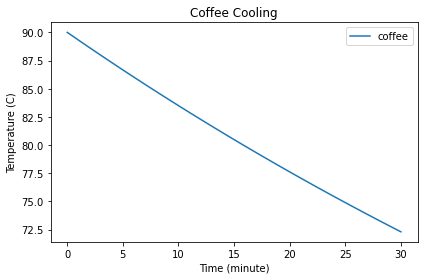

In [10]:
from modsim import decorate

results.plot(label='coffee')

decorate(xlabel='Time (minute)',
         ylabel='Temperature (C)',
         title='Coffee Cooling')

## Exercises

**Exercise:**  Simulate the temperature of 50 mL of milk with a starting temperature of 5 degC, in a vessel with the same insulation, for 15 minutes, and plot the results.

By trial and error, find a value for `r` that makes the final temperature close to 20 C.

In [83]:
# Solution

milk = make_system(T_init=5, t_end=15, r=0.133, volume=50)
results_milk = run_simulation(milk, change_func)
milk.T_final

20.00135627897414

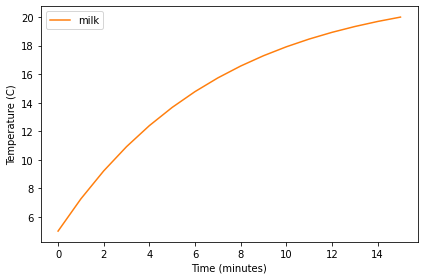

In [85]:
# Solution

results_milk.plot(color='C1', label='milk')

decorate(xlabel='Time (minutes)',
         ylabel='Temperature (C)')